# wk4 Demo - Intro to Spark
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Spring 2019`__

Last week we saw a number of design patterns in Hadoop MapReduce. This week we will look at the limitations of Hadoop MapReduce when it comes to running iterative jobs and preview the advantages of modern distributed compuation frameworks like Spark. By abstracting away many of the parallelization details Spark provides a flexible interface for the programmer. However a word of warning: don't let the ease of implementation lull you into complacency, scalable solutions still require attention to the details of smart algorithm design. 

In class today we'll get some practice working with Spark RDDS. We'll use Spark to re-implement each of the tasks that you performed using the Command Line or Hadoop Streaming in weeks 1-3 of the course. Our goal is to get you up to speed and coding in Spark as quickly as possible; this is by no means a comprehensive tutorial. By the end of today's demo you should be able to:  
* ... __initialize__ a `SparkSession` in a local NB and use it to run a Spark Job.
* ... __access__ the Spark Job Tracker UI.
* ... __describe__ and __create__ RDDs from files or local Python objects.
* ... __explain__ the difference between actions and transformations.
* ... __decide__ when to `cache` or `broadcast` part of your data.
* ... __implement__ Word Counting, Sorting and Naive Bayes in Spark. 

__`NOTE:`__ Although RDD successor datatype, Spark dataframes, are becoming more common in production settings we've made a deliberate choice to teach you RDDs first beause building homegrown algorithm implementations is crucial to developing a deep understanding of machine learning and parallelization concepts -- which is the goal of this course. We'll still touch on dataframes in Week 5 when talking about Spark efficiency considerations and we'll do a deep dive into Spark dataframes and streaming solutions in Week 12.

__`Additional Resources:`__ The offical documentation pages offer a user friendly overview of the material covered in this week's readings: [Spark RDD Programming Guide](https://spark.apache.org/docs/latest/rdd-programming-guide.html#rdd-programming-guide).

__RDD API docs__: https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD

### Notebook Set-Up

In [1]:
# imports
import re
import numpy as np
import pandas as pd

In [2]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [3]:
# make data directory if it doesn't already exist
!mkdir data

mkdir: cannot create directory `data': File exists


### Load the data
Today we'll mostly be working with toy examples & data created on the fly in Python. However at the end of this demo we'll revisit Word Count & Naive Bayes using some of the data from weeks 1-3. Run the following cells to re-load the _Alice in Wonderland_ text & the 'Chinese' toy example.

In [4]:
# (re)download alice.txt used in HW1
!curl "http://www.gutenberg.org/files/11/11-0.txt" -o data/alice.txt
ALICE_TXT = PWD + "/data/alice.txt"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  169k  100  169k    0     0   254k      0 --:--:-- --:--:-- --:--:--  253k


In [5]:
%%writefile data/chineseTrain.txt
D1	1		Chinese Beijing Chinese
D2	1		Chinese Chinese Shanghai
D3	1		Chinese Macao
D4	0		Tokyo Japan Chinese

Overwriting data/chineseTrain.txt


In [6]:
%%writefile data/chineseTest.txt
D5	1		Chinese Chinese Chinese Tokyo Japan
D6	1		Beijing Shanghai Trade
D7	0		Japan Macao Tokyo
D8	0		Tokyo Japan Trade

Overwriting data/chineseTest.txt


In [4]:
# naive bayes toy example data paths - ADJUST AS NEEDED
TRAIN_PATH = PWD + "/data/chineseTrain.txt"
TEST_PATH = PWD + "/data/chineseTest.txt"

# Exercise 1. Getting started with Spark. 
For week 4 you read Ch 3-4 from _Learning Spark: Lightning-Fast Big Data Analysis_ by Karau et. al. as well as a few blog posts that set the stage for Spark. From these readings you should be familiar with each of the following terms:

* __Spark session__
* __Spark context__
* __driver program__
* __executor nodes__
* __resilient distributed datasets (RDDs)__
* __pair RDDs__
* __actions__ and __transformations__
* __lazy evaluation__

The first code block below shows you how to start a `SparkSession` in a Jupyter Notebook. Next we show a simple example of creating and transforming a Spark RDD. Let's use this as a quick vocab review before we dive into more interesting examples. 

In [11]:
from pyspark.sql import SparkSession
app_name = "wk4_demo"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [13]:
sc.getConf().getAll()

[('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.app.name', 'wk4_demo'),
 ('spark.master', 'local[*]'),
 ('spark.app.id', 'local-1568946931995'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '33179'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.host', 'docker.w261')]

In [9]:
# a small example
myData_RDD = sc.parallelize(range(1,100))
squares_RDD = myData_RDD.map(lambda x: (x,x**2))
oddSquares = squares_RDD.filter(lambda x: x[1] % 2 == 1)

In [10]:
oddSquares.take(5)

[(1, 1), (3, 9), (5, 25), (7, 49), (9, 81)]

 > __DISCUSSION QUESTIONS:__ For each key term from the reading, briefly explain what it means in the context of this demo code. Specifically:
 * _What is the 'driver program' here?_
 * _What does the spark context do? Do we have 'executors' per se?_
 * _List all RDDs and pair RDDs present in this example._
 * _List all transformations present in this example._
 * _List all actions present in this example._
 * _What does the concept of 'lazy evaluation' mean about the time it would take to run each cell in the example?_
 * _If we were working on a cluster, where would each transformation happen? would the data get shuffled?_

__INSTRUCTOR TALKING POINTS__
* What is the 'driver program' here?
> The driver program is the code we write here in this Jupyter Notebook.

* What does the spark context do? Do we have 'executors' per se?
> Driver programs access Spark through a SparkContext object, which represents a
connection to a computing cluster. Once you have a SparkContext, you can use it to build RDDs. 
> 
> The spark context is a local object that details a set of configuration parameters for running Spark jobs. Among other things it determines how many executors will run on each node in your cluster & what resources will be allotted to each one. In this case we're running Spark in local mode which means that we're using a pseudo cluster -- instead of executors each running with their own JVM (Java Virtual Machine) on various linked machines, in local mode Spark will use the same JVM for all the execution task & the driver itself.

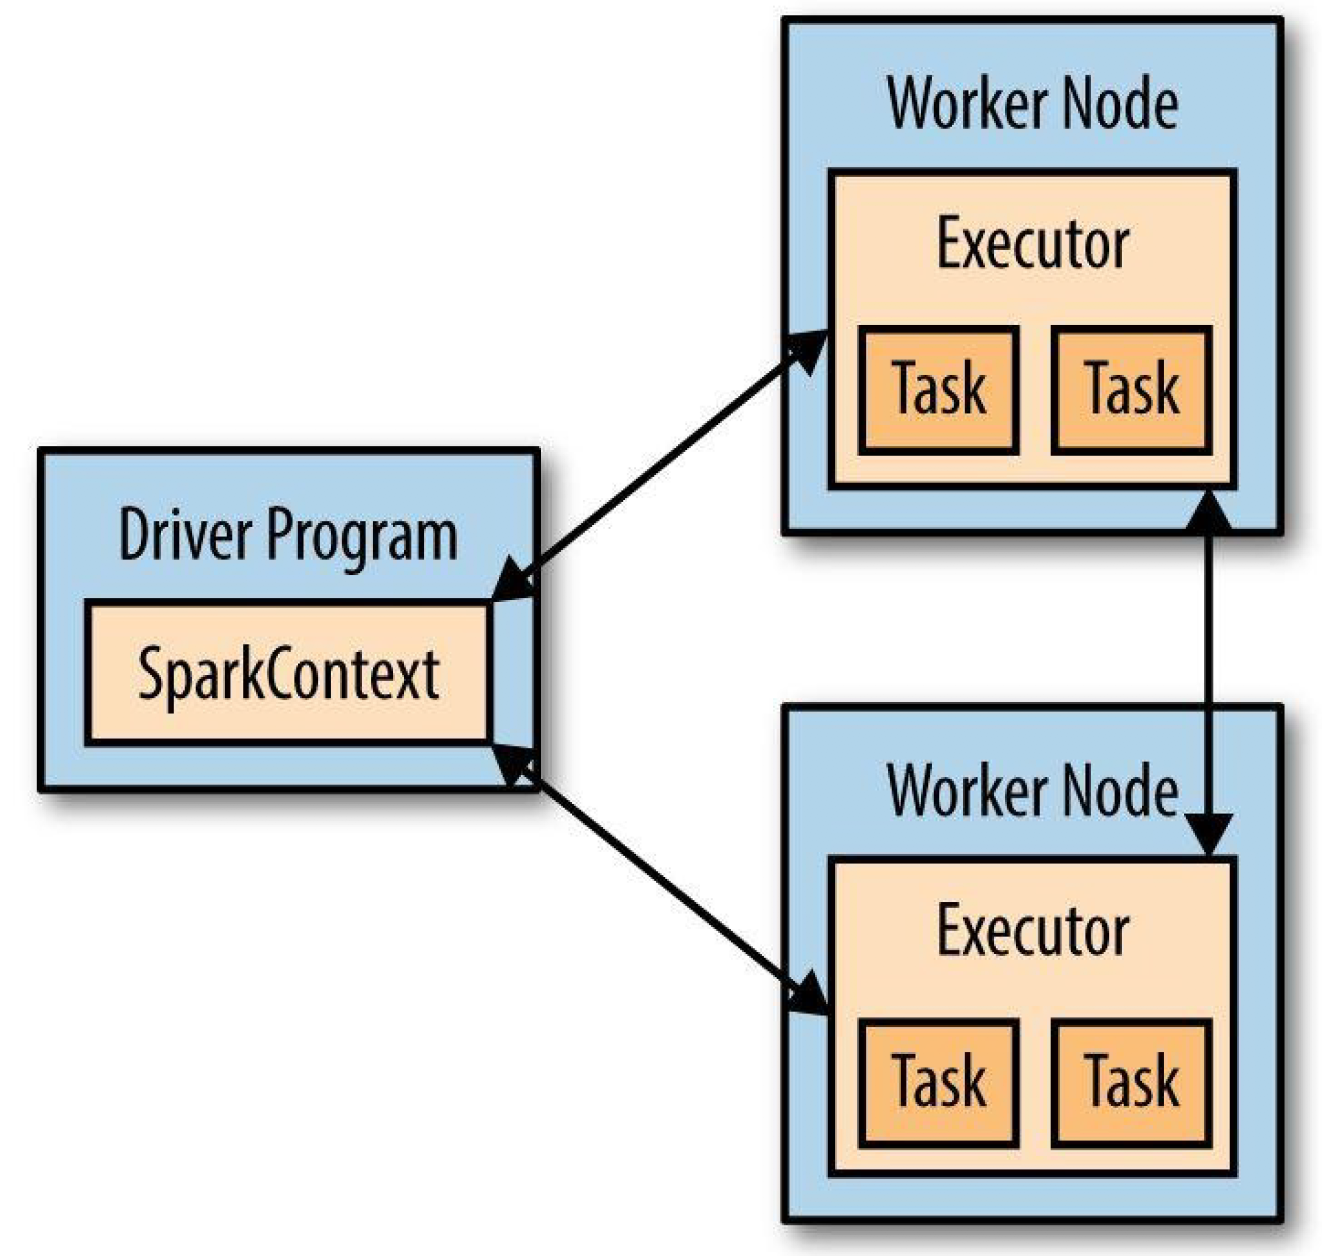

In [9]:
from IPython.display import Image 
Image(filename="spark-context.png")

* List all RDDs and pair RDDs present in this example.
> RDDs: `myData`; Pair RDDs: `squares` and `oddSquares`


* List all transformations present in this example.
> `map()` and `filter()`

* List all actions present in this example.
> `take()`

* What does the concept of 'lazy evaluation' mean about the time it would take to run each cell in the example?
> Lazy evaluation means that Spark keeps track of a directed acyclic graph (DAG) that contains the list of transformations needed to recreate each RDD and only actually performs those transformations when an action is called. This means that when we run the cell with 3 lines of code, no transformations actually happen, whereas running the `take` action triggers the computation to start.

* If we were working on a cluster, where would each transformation happen? would the data get shuffled?
> There are two transformations in this code: map and filter. Both will happen on the nodes where the data are located. The data will not be shuffled in this code.

# Exercise 2. RDD transformations warm ups.

Here are some more examples of Spark transformations and actions. For each task below, we've provided a few different implementations. Read each example and discuss the differences. Is one implementation better than the other or are the differences cosmetic? You may wish to discuss:
* the format of the data after each transformation
* memory usage (on executor nodes & in the driver)
* time complexity
* amount of network transfer
* whether or not the data will get shuffled
* coding efficiency & readability  

Although we're working with tiny demo examples for now, try to imagine how the same code would operate if we were running a large job on a cluster. To aid in your analysis, navigate to the Spark UI (available at http://localhost:4040). To start, you should see a single job -- the job from Exercise 1. Click on the job description to view the DAG for that job. Check back with this UI as you run each version of the tasks below (__Note__: _the stages tab may be particularly helpful when making your comparisons_).

#### a) Multiples of 5 and 7

In [2]:
# VERSION 1
dataRDD = sc.parallelize(range(1,100))
fivesRDD = dataRDD.filter(lambda x: x % 5 == 0)
sevensRDD = dataRDD.filter(lambda x: x % 7 == 0)
result = fivesRDD.intersection(sevensRDD)
result.collect()

[35, 70]

In [3]:
# VERSION 2
dataRDD = sc.parallelize(range(1,100))
result = dataRDD.filter(lambda x: x % 5 == 0)\
                .filter(lambda x: x % 7 == 0)
result.collect()

[35, 70]

In [4]:
# VERSION 3
dataRDD = sc.parallelize(range(1,100))
result = dataRDD.filter(lambda x: x % 7 == 0 and x % 5 == 0)
result.collect()

[35, 70]

>__DISCUSSION QUESTION:__ 
* What is the task here? Compare/contrast these three implementations.  
* Which of these versions require a shuffle? How do you know?

__INSTRUCTOR TALKING POINTS__
> __notes:__
> Version 1 requires a shuffle, the others don't.   
> Versions 2 and 3 are exectly the same. Spark performs several optimizations, such as __“pipelining”__ filter, map, and other such transformations together to merge them. Pipelining allows for a single pass over the data whenever possible instead of creating new RDDs. Pipelining occurs when RDDs can be computed from their parents without data movement. 
>
> __debugging note:__ _when you are first starting in Spark its a good idea to debug each step in isolation. If you are writing in the style of Version 1 you can do this by calling `collect()` on each RDD, if you are coding in the style of Version 2 you would comment out each line then uncomment one by one._


#### b) Pig Latin Translator

In [13]:
poem = ["A bear however hard he tries", 
        "Grows tubby without exercise", 
        "said AA Milne"]

In [14]:
# VERSION 1
def translate(sent):
    words = [w[1:] + w[0] + '-ay' for w in sent.lower().split()]
    return ' '.join(words)

poemRDD = sc.parallelize(poem)
result = poemRDD.map(translate)\
                .reduce(lambda x,y: x + ' ' + y)
print(result)

a-ay earb-ay oweverh-ay ardh-ay eh-ay riest-ay rowsg-ay ubbyt-ay ithoutw-ay xercisee-ay aids-ay aa-ay ilnem-ay


In [15]:
# VERSION 2
def translate(wrd):
    return wrd[1:] + wrd[0] + '-ay'

poemRDD = sc.parallelize(poem)
result = poemRDD.flatMap(lambda x: x.lower().split())\
                .map(translate)\
                .reduce(lambda x,y: x + ' ' + y)
print(result)

a-ay earb-ay oweverh-ay ardh-ay eh-ay riest-ay rowsg-ay ubbyt-ay ithoutw-ay xercisee-ay aids-ay aa-ay ilnem-ay


>__DISCUSSION QUESTION:__ What is the task here? Compare/contrast these two implementations.

__INSTRUCTOR TALKING POINTS__
> __main point:__ `map()` vs. `flatMap()`  
> __notes:__ Version 1 is translating by phrase, Version 2 by word.   
> The difference here is _mostly_ cosmetic.  
> V2 causes more records to be created, but ultimately the same amount of data has to be sent across the network either way. The extra map in V2 happens locally on each executor by default (yay Spark opimizations) & `flatMap` returns a generator so that extra step is not actually increasing the computational complexity of this solution.
> __syntax tip:__ _If you are new to pyspark, take a moment to note the syntax in both versions where we pass our python translation function directly to the mapper._

#### c) Average Monthly Purchases

In [16]:
shoppingList = ["JAN: 5 apples, 15 oranges",
                "FEB: 10 apples, 10 oranges",
                "MAR: 3 apples, 1 oranges",
                "APR: 6 apples, 2 oranges"]

In [17]:
# helper function
def parseShopping(line):
    """Parse each month's shopping list string into a key-value iterator."""
    month, items = line.split(':')
    items = [item.strip().split(' ') for item in items.split(',')]
    return [(i[1], int(i[0])) for i in items]

In [18]:
# VERSION 1  (example 4-7 from Learning Spark)
shoppingRDD = sc.parallelize(shoppingList)
result = shoppingRDD.flatMap(lambda x: parseShopping(x))\
                    .mapValues(lambda x: (x,1))\
                    .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))\
                    .mapValues(lambda x: x[0]/float(x[1]))
result.collect()

[('apples', 6.0), ('oranges', 7.0)]

In [19]:
# VERSION 2 (example 4-12 from Learning Spark)
shoppingRDD = sc.parallelize(shoppingList)
result = shoppingRDD.flatMap(lambda x: parseShopping(x))\
                    .combineByKey(lambda x: (x,1),       # action for new key
                                  lambda x, y: (x[0] + y, x[1] + 1), # action for repeat key
                                  lambda x, y: (x[0] + y[0], x[1] + y[1]))\
                    .mapValues(lambda x: x[0]/float(x[1]))
result.collect()

[('apples', 6.0), ('oranges', 7.0)]

In [20]:
# VERSION 3
shoppingRDD = sc.parallelize(shoppingList)
result = shoppingRDD.flatMap(lambda x: parseShopping(x))\
                    .groupByKey()\
                    .mapValues(lambda x: sum(x)/float(len(x)))
result.collect()

[('apples', 6.0), ('oranges', 7.0)]

>__DISCUSSION QUESTION:__ What is the task here? Compare/contrast these three implementations.

__INSTRUCTOR TALKING POINTS__
> __main point:__ Combine early shuffle late.  
> __notes:__ V1 and V2 are equivalent. V3 is worse on large data.  
Spark automatically applies `reduceByKey()` and `combineByKey()` locally before shuffling anything.  
In V3 the groupByKey call would cause the items to be shuffled which is a lot more network traffic than the alternative solutions in which we aggregate by key on each executor before doing any global aggregations.
>
> Many sources—including the Spark documentation—warn against the scalability of the __groupByKey__ function, which returns an iterator of each element by key. __groupByKey__ is known to cause memory errors at scale. The reason is that the “groups” created by __groupByKey__ are always iterators, which can’t be distributed. This causes an expensive “shuffled read” step in which Spark has to read all of the shuffled data from disk and into memory. _From High Perfomance Spark, p.134_

#  Exercise 3. cache()-ing

In exercise 2 you saw how Spark builds an execution plan (DAG) so that transformations are evaluated lazily when triggerd by an action. In more complex DAGs you may need to reuse the contents of an RDD for multiple downstream operations. In such cases we'd like to avoid duplicating the computation of that intermediate result. Spark offers a few different options to persist an RDD in memory on the executor node where it is stored. Of these the most common is `cache()` (you'll read about others next week in ch 5 from _High Performance Spark_). Lets briefly look at how to `cache()` an RDD and discus when doing so is to your advantage.

In [21]:
# initialize data
dataRDD = sc.parallelize(np.random.random_sample(1000))   

In [22]:
# perform some transformations
data2X= dataRDD.map(lambda x: x*2)
dataGreaterThan1 = data2X.filter(lambda x: x > 1.0)
cachedRDD = dataGreaterThan1.cache()

In [23]:
# count results less than 1
cachedRDD.filter(lambda x: x<1).count()

0

In [24]:
# count results greater than 1
cachedRDD.filter(lambda x: x>1).count()

523

In [26]:
# look at 10 results
for line in cachedRDD.take(10):
    print(line)

1.6667453250678368
1.7614593992720953
1.2988831829895016
1.0410882546629787
1.099743895396421
1.282848349510748
1.476745379132667
1.0343697664095308
1.216949704301669
1.497202956544192


In [27]:
# look at top 10 results
for line in cachedRDD.top(10):
    print(line)

1.9992739091003875
1.9986245266558205
1.997688102449301
1.9969190384384075
1.9957310373910453
1.9934067725736477
1.9913641512918285
1.990903465353988
1.9903027088746514
1.9878550497322187


In [28]:
# look at top 10 results
for line in cachedRDD.takeOrdered(10):
    print(line)

1.0003893698547939
1.0035314681149836
1.0057640328593225
1.0068468600371119
1.008806428308111
1.0099051727481616
1.012035891220238
1.0131913368287693
1.0151454056093803
1.020104710645641


> __DISCUSSION QUESTIONS:__
* How many total actions are there in the 7 cells above?
* If we hadn't cached the `dataGreaterThan1` RDD what would happen each time we call an action?
* How does `cache()` change what the framework does? 
* When does it _not_ make sense to `cache()` an intermediate result?

__INSTRUCTOR TALKING POINTS__
* How many total actions are there in the 7 cells above?
>  This code includes 4 transformations: `map()`, `filter()`, `filter()`, `filter()`, and 5 actions: `count()`,`count()`,`take()`,`top()`,`takeOrdered()`

* If we hadn't cached the dataGreaterThan1 RDD what would happen each time we call an action?
> The DAG would re run from scratch.

* How does cache() change what the framework does?
> It holds partial results in memory on the nodes where that data was computed so that subsequent transformations don't get recomputed from scratch.
>
> Persisting an RDD means materializing an RDD (usually by storing it in-memory onthe executors), for reuse during the current job. Spark remembers a persisted RDD’s lineage so that it can recompute it for the duration of a Spark job if one of the persisted partitions is lost. ( cache() is equivalent to per
sist(), which is equivalent to persist("MEMORY_ONLY"). )

* When does it not make sense to cache() an intermediate result?
> Cache()-ing makes sense when an intermediate result will be used in multiple downstream transformations.


__MORE INFO__: _High Performance Spark, p. 116: Types of Reuse: Cache, Persist, Checkpoint, Shuffle Files_

# Exercise 4. broadcast()-ing

Another challenge we faced when designing Hadoop MapReduce jobs was the challenge of making key pieces of information available to multiple nodes so that certain computations can happen in parallel. In Hadoop Streaming we resolved this challenge using custom partition keys and the order inversion pattern. In Spark we'll use broadcast variables -- read only objects that Spark will ship to all nodes where they're needed. Here's a brief example of how to create and access a broadcast variable.

Run the following cell to create our sample data files: a list of customers & a list of cities.

In [26]:
%%writefile data/customers.csv
Quinn Frank,94703
Morris Hardy,19875
Tara Smith,12204
Seth Mitchell,38655
Finley Cowell,10005
Cory Townsend,94703
Mira Vine,94016
Lea Green,70118
V Neeman,16604
Tvei Qin,70118

Overwriting data/customers.csv


In [8]:
%%writefile data/zipCodes.csv
94703,Berkeley,CA
94016,San Francisco,CA
10005,New York,NY
12204,Albany,NY
38655,Oxford,MS
70118,New Orleans,LA

Overwriting data/zipCodes.csv


Spark Job to count customers by state.

In [9]:
# load customers from file
dataRDD = sc.textFile('data/customers.csv')

In [10]:
# create a look up dictionary to map zip codes to state abbreviations
zipCodes = {l.split(',')[0]:l.split(',')[2] 
            for l in open('data/zipCodes.csv', 'r').read().split('\n')}
zipCodes = sc.broadcast(zipCodes) 

In [11]:
# count by state
result = dataRDD.map(lambda x: x.split(',')[1])\
                .map(lambda x: (zipCodes.value.get(x,'n/a'),1))\
                .reduceByKey(lambda a, b: a + b)

In [12]:
# take a look
result.collect()

[('CA', 3), ('NY', 2), ('LA', 2), ('n/a', 2), ('MS', 1)]

> __DISCUSSION QUESTIONS:__
* What does broadcasting achieve here?
* Why not just encapsulate our variables in a function closure instead?
* When would it be a bad idea to broadcast a supplemental table like our list of zip codes?
* Note that we are working in local mode through out this notebook. What happens if you comment out the line where we broadcast the zip code dictionary? What would happen if you were working on a cluster?

__INSTRUCTOR TALKING POINTS__  
* What does broadcasting achieve here?
> Broadcasting makes a piece of information available to all the executors -- in this case it sends the look up dictionary of zipCodes to each node so that that dictionary can be used in the second map.

* Why not just encapsulate our variables in a function closure instead?
> One way to use a variable in your driver node inside your tasks is to simply reference it in your function closures (e.g., in a `map` operation), but this can be inefficient, especially for large variables such as a lookup table or a machine learning model. The reason for this is that when you use a variable in a closure, it must be deserialized on the worker nodes many times (one per task). Moreover, if you use  the same variable in multiple Spark actions and jobs, it will be re-sent to the workers with every job instead of once.

* When would it be a bad idea to broadcast a supplemental table like our list of zip codes?
> We wouldn't want to do this for really large files/objects.

* Note that we are working in local mode through out this notebook. What happens if you comment out the line where we broadcast the zip code dictionary? What would happen if you were working on a cluster?
> In local mode the driver is running in the same JVM as the executors so the code actually runs fine even if we comment out the broadcast. On a cluster, the zipCodes would be sent to each task via encapsulation resulting in a less efficient implementation.

__` Syntax Note:`__ _If you are new to pyspark pay careful attention to how we access the dictionary that is broadcast._

# Exercise 5. Accumulators

Accumulators are Spark's equivalent of Hadoop counters. Like broadcast variables they represent shared information across the nodes in your cluster, but unlike broadcast variables accumulators are _write-only_ ... in other words you can only access their values in the driver program and not on your executors (where transformations are applied). As convenient as this sounds, there are a few common pitfalls to avoid. Let's take a look.

Run the following cell to create a sample data file representing a list of `studentID, courseID, final_grade`...

In [33]:
%%writefile data/grades.csv
10001,101,98
10001,102,87
10002,101,75
10002,102,55
10002,103,80
10003,102,45
10003,103,75
10004,101,90
10005,101,85
10005,103,60

Overwriting data/grades.csv


Suppose we want to compute the average grade by course and student while also tracking the number of failing grades awarded. We might try something like this:

In [34]:
# initialize an accumulator to track failing grades
nFailing = sc.accumulator(0)

In [35]:
# function to increment the accumulator as we read in the data
def parse_grades(line, accumulator):
    """Helper function to parse input & track failing grades."""
    student,course,grade = line.split(',')
    grade = int(grade)
    if grade < 65:
        accumulator.add(1)
    return(student,course, grade)

In [36]:
# compute averages in spark
gradesRDD = sc.textFile('data/grades.csv')\
              .map(lambda x: parse_grades(x, nFailing))
studentAvgs = gradesRDD.map(lambda x: (x[0], (x[2], 1)))\
                       .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
                       .mapValues(lambda x: x[0]/x[1])
courseAvgs = gradesRDD.map(lambda x: (x[1], (x[2], 1)))\
                      .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
                      .mapValues(lambda x: x[0]/x[1])

In [37]:
# take a look
print("===== average by student =====")
print(studentAvgs.collect())
print("===== average by course =====")
print(courseAvgs.collect())
print("===== number of failing grades awarded =====")
print(nFailing)

===== average by student =====
[('10001', 92.5), ('10004', 90.0), ('10002', 70.0), ('10003', 60.0), ('10005', 72.5)]
===== average by course =====
[('102', 62.333333333333336), ('101', 87.0), ('103', 71.66666666666667)]
===== number of failing grades awarded =====
6


> __DISCUSSION QUESTIONS:__
* What is wrong with the results? (__`HINT:`__ _how many failing grades are there really?_)
* Why might this be happening? (__`HINT:`__ _How many actions are there in this code? Which parts of the DAG are recomputed for each of these actions?_)
* What one line could we add to the code to fix this problem?
  * What could go wrong with our "fix"?
* How could we have designed our parser differently to avoid this problem in the first place?

__INSTRUCTOR TALKING POINTS__
* What is wrong with the results? (HINT: how many failing grades are there really?)
> There are actually only 3 failing grades but the accumulators seems to have found 6.

* Why might this be happening? (HINT: How many actions are there in this code? Which parts of the DAG are recomputed for each of these actions?)
> We have two actions here -- one to print out `studentAvgs` and another to print `courseAvgs`. Since both of these RDDs are built from `gradesRDD` the code to create `gradesRDD`, which includes the map function where our accumulator is incremented, gets run twice. We're double counting the failing grades.

* What one line could we add to the code to fix this problem?
> If we add a `cache()` statement to the end of the code for `gradesRDD` we could instruct Spark to only compute that intermediate RDD once which would prevent the double counting problem.

* What could go wrong with our fix?
> If the transformation task failed and had to be rerun, the accumulator would be incremented again. For accumulator updates performed inside __actions only__, Spark guarantees that each task’s update to the accumulator will only be applied once, i.e. restarted tasks will not update the value. In transformations, users should be aware of that each task’s update may be applied more than once if tasks or job stages are re-executed. For more on accumulators, see also the __foreach()__ action.

* How could we have designed our parser differently to avoid this problem in the first place?
> Alternately, if we knew the two downstream tasks from the outset, we could have written a parser that emits two records per line: one for the student one for the course... that way we could use a composite key to compute the averages for courses and students in a single job and the accumulator would only get incremented once.

# Exercise 6. WordCount & Naive Bayes Reprise

We'll wrap up today's demo by revisiting two tasks from weeks 1-2. Compare each of these Spark implementations to the approach we took when performing the same task in Hadoop MapReduce.

### a) Word Count in Spark

In [40]:
# load the data into Spark
aliceRDD = sc.textFile(ALICE_TXT)

In [41]:
# perform wordcount
result = aliceRDD.flatMap(lambda line: re.findall('[a-z]+', line.lower())) \
                 .map(lambda word: (word, 1)) \
                 .reduceByKey(lambda a, b: a + b)\
                 .cache()

In [42]:
# take a look at the top 10 (by alphabet)
result.takeOrdered(10)

[('a', 690),
 ('abide', 2),
 ('able', 1),
 ('about', 102),
 ('above', 3),
 ('absence', 1),
 ('absurd', 2),
 ('accept', 1),
 ('acceptance', 1),
 ('accepted', 2)]

In [43]:
# take a look at the top 10 (by count)
result.takeOrdered(10, key=lambda x: -x[1])

[('the', 1818),
 ('and', 940),
 ('to', 809),
 ('a', 690),
 ('of', 631),
 ('it', 610),
 ('she', 553),
 ('i', 545),
 ('you', 481),
 ('said', 462)]

In [44]:
# what does Spark consider the 'top'?
result.top(10)

[('zip', 1),
 ('zigzag', 1),
 ('zealand', 1),
 ('youth', 6),
 ('yourself', 10),
 ('yours', 3),
 ('your', 71),
 ('young', 5),
 ('you', 481),
 ('yet', 25)]

> __DICUSSION QUESTIONS:__
* Compare/contrast this implementation to our Hadoop Streaming approach.
* How many times does the data get shuffled?
* What local aggregation will spark do?
* What is the difference between `take()` and `top()` and `takeOrdered()`? Is one more or less efficient than the others? Compare these actions to the work we had to do to sort and subset with multiple reducers in Hadoop MapReduce?
* What would happen if we removed the `cache()` that follows the `reduceByKey()`? [__`Hint:`__ _this is kind of a trick question, but try rerunning the job & look at the Spark UI..._]

__INSTRUCTOR TALKING POINTS__
* Compare/contrast this implementation to our Hadoop Streaming approach.
> The basic approach: tokenize, create counters, aggregate by key is identical to what we did in Hadoop MapReduce... but the code is dramatically shorter. Significantly, we don't need to specify any special configuration to access data with a secondary sort or to ensure load balancing, etc. 

* How many times does the data get shuffled?
> Once for the `reduceByKey()` operation. Note that this is different than the equivalent task in Hadoop - where word count w/ secondary sort required one shuffle for the aggregation and a second shuffle for the sorting by count -- to confirm this navigate to http://localhost:4040/jobs and look at the Shuffle Read/Write statistics.

* What local aggregation will Spark do?
> When we use `reduceByKey()` Spark will automatically reduce locally before shuffling. This is one of the reasons we usually would rather use `reduceByKey` (or combine by key) instead of `groupByKey()` followed by a `map()`.

* What is the difference between `take()` and `top()` and `takeOrdered()`? Is one more or less efficient than the others? Compare these actions to the work we had to do to sort and subset with multiple reducers in Hadoop MapReduce?
> These are different ways to pull subsets of the results back into the driver program. `take()` returns the specified number of elements from the first RDD. `top()` returns the first 10 elemens using the default ordering (in this case reverse alphabetical by key). `takeOrdered()` has an optional second parameter that allows the user to define a custom ordering. What's interesting is that none of these actions trigger a shuffle (again, confirm using the UI)... 

* What would happen if we removed the `cache()` that follows the `reduceByKey()`? [__`Hint:`__ _this is kind of a trick question, but try rerunning the job & look at the Spark UI..._]
> In theory removing the `cache()` would mean that each subsequent action causes the transformations to start from scratch - which would mean we do a shuffle each time which would be inefficient. However actually whenever you use a `ByKey()` transformation Spark automatically `caches()` the result (doing so is part of how it ensures the fault tolerance of the shuffle)... so actually removing the explicit instruction to `cache()` won't make a difference here.

### b) Naive Bayes in Spark
Implement the algorithm (training & inference)

In [45]:
def parse(doc):
    """
    Helper Function to parse documents.
    """
    docID, class_, subj, body = doc.lower().split('\t')
    return(class_, subj + " " + body)

In [46]:
def tokenize(class_, text):
    """
    Map text from a given class to word list with counts for each class. 
    """
    # get words                       
    words = re.findall(r'[a-z]+', text)
    # emit a count for each class (0,1 or 1,0)
    class_counts = [1,0] if class_ =='0' else [0,1]
    return[(word, class_counts) for word in words]

In [47]:
def NBtrain(dataRDD, smoothing = 1.0):
    """
    Function to train a Naive Bayes Model in Spark.
    Returns a dictionary.
    """
    # extract word counts
    docsRDD = dataRDD.map(parse)
    wordsRDD = docsRDD.flatMap(lambda x: tokenize(*x)).cache()\
                      .reduceByKey(lambda x,y: np.array(x) + np.array(y))\
                      .cache()
    # compute priors
    docTotals = docsRDD.countByKey()
    priors = np.array([docTotals['0'], docTotals['1']])
    priors = priors/sum(priors)
    
    # compute conditionals
    wordTotals = sc.broadcast(wordsRDD.map(lambda x: x[1] + np.array([smoothing, smoothing]))\
                                      .reduce(lambda x,y: np.array(x) + np.array(y)))
    cProb = wordsRDD.mapValues(lambda x: x + np.array([smoothing, smoothing]))\
                    .mapValues(lambda x: x/np.array(wordTotals.value))\
                    .collect()
    
    return dict([("ClassPriors", priors)] + cProb)

In [48]:
def NBclassify(document, model_dict):
    """
    Classify a document as ham/spam via Naive Bayes.
    Use logProbabilities to avoid floating point error.
    NOTE: this is just a python function, no distribution so 
    we should expect our documents (& model) to fit in memory.
    """
    # get words                       
    words = re.findall(r'[a-z]+', document.lower())
    # compute log probabilities
    logProbs = [np.log(model_dict.get(wrd,[1,1])) for wrd in words]
    # return most likely class
    sumLogProbs = np.log(model_dict['ClassPriors']) + sum(logProbs)
    return np.argmax(sumLogProbs)

In [49]:
def evaluate(resultsRDD):
    """
    Compute accuracy, precision, recall an F1 score given a
    pairRDD of (true_class, predicted_class)
    """
    nDocs = resultsRDD.count()
    TP = resultsRDD.filter(lambda x: x[0] == '1' and x[1] == 1).count()
    TN = resultsRDD.filter(lambda x: x[0] == '0' and x[1] == 0).count()
    FP = resultsRDD.filter(lambda x: x[0] == '0' and x[1] == 1).count()
    FN = resultsRDD.filter(lambda x: x[0] == '1' and x[1] == 0).count()
    
    # report results 
    print(f"Total # Documents:\t{nDocs}")
    print(f"True Positives:\t{TP}") 
    print(f"True Negatives:\t{TN}")
    print(f"False Positives:\t{FP}")
    print(f"False Negatives:\t{FN}") 
    print(f"Accuracy\t{(TP + TN)/(TP + TN + FP + FN)}")
    if (TP + FP) != 0:  
        precision = TP / (TP + FP)  
        print(f"Precision\t{precision}")
    if (TP + FN) != 0: 
        recall = TP / (TP + FN) 
        print(f"Recall\t{recall}") 
    if TP != 0: 
        f_score = 2 * precision * recall / (precision + recall)
        print(f"F-Score\t{f_score}")

Retrieve results.

In [50]:
# load data into Spark
trainRDD = sc.textFile(TRAIN_PATH)
testRDD = sc.textFile(TEST_PATH)

In [51]:
# train your model (& take a look)
NBmodel = NBtrain(trainRDD)
NBmodel

{'ClassPriors': array([0.25, 0.75]),
 'chinese': array([0.22222222, 0.42857143]),
 'macao': array([0.11111111, 0.14285714]),
 'japan': array([0.22222222, 0.07142857]),
 'beijing': array([0.11111111, 0.14285714]),
 'shanghai': array([0.11111111, 0.14285714]),
 'tokyo': array([0.22222222, 0.07142857])}

In [52]:
# perform inference on a doc (just to test)
NBclassify("This Japan Tokyo Macao is Chinese", NBmodel)

0

In [53]:
# evaluate your model
model_b = sc.broadcast(NBmodel)
resultsRDD = testRDD.map(parse)\
                    .mapValues(lambda x: NBclassify(x, model_b.value))
evaluate(resultsRDD)

Total # Documents:	4
True Positives:	2
True Negatives:	2
False Positives:	0
False Negatives:	0
Accuracy	1.0
Precision	1.0
Recall	1.0
F-Score	1.0


> __DICUSSION QUESTIONS:__
* Compare/contrast this implementation to our Hadoop Streaming approach.

__INSTRUCTOR TALKING POINTS__
* Compare/contrast this implementation to our Hadoop Streaming approach.
> Again, the basic architecture of the implementation should be recognizable... but the code itself is much more compact.

# Bonus

## Relative Frequencies
__Data Intensive Text Processing__   
Lin and Dyer   
3.3 COMPUTING RELATIVE FREQUENCIES   
(ported to Spark RDD API)

In [52]:
sc.stop()

In [53]:
from pyspark.sql import SparkSession
app_name = "relative_frequencies"
master = "local[*]" # use all available cores in local mode
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [54]:
data = ['dog,aardvark,pig,banana','bear,zebra,pig']
data_RDD = sc.parallelize(data)
data_RDD.glom().collect()
# using glom, we can see that there were as many partitions created as there are cores on this machine

[[], ['dog,aardvark,pig,banana'], [], ['bear,zebra,pig']]

In [59]:
from itertools import combinations

def makePairs(row):
    words = row.split(',')
    for w1, w2 in combinations(words, 2):
        yield((w1,"*"),1)
        yield((w1,w2),1)

def partitionByWord(x):
    return hash(x[0][0])

def calcRelFreq(row):    
    currPair, currWord, pairTotal, wordTotal = None, None, 0, 0
    for r in list(row):
        w1, w2 = r[0][0], r[0][1]
        if w2 == "*":
            if w1 != currWord: 
                wordTotal = 0
                currWord = w1
            wordTotal += r[1]    
        else:
            pairTotal += r[1]
        
            if currPair != r[0]: 
                yield(w1+" - "+w2, pairTotal/wordTotal)
                pairTotal = 0
                currPair = r[0]

In [60]:
rdd = data_RDD.flatMap(makePairs)\
              .repartitionAndSortWithinPartitions(numPartitions=5, 
                                                  ascending=True, 
                                                  partitionFunc=partitionByWord,
                                                  keyfunc=lambda x: (x[0],x[1]))\
              .mapPartitions(calcRelFreq)

rdd.glom().collect()

[[],
 [],
 [],
 [('dog - aardvark', 0.3333333333333333),
  ('dog - banana', 0.3333333333333333),
  ('dog - pig', 0.3333333333333333)],
 [('aardvark - banana', 0.5),
  ('aardvark - pig', 0.5),
  ('bear - pig', 0.5),
  ('bear - zebra', 0.5),
  ('pig - banana', 1.0),
  ('zebra - pig', 1.0)]]

__NOTE:__   
There is little opprotunity for combining in this implementation. A combineByKey function might be well suited here after the flatMap. Exercise for the reader: implement combiners and compare performance. You will probably need a bigger corpus to be able to make meaningful comparisons.